Membuat sebuah model yang dapat memprediksi setidaknya 60% dari pelanggan yang akan mengalami telat bayar kartu kredit [Accuracy & Recall di atas 60%]

#**Experiment**
Periode Tinjauan:
1. Nasabah direview selama satu tahun terakhir
2. Nasabah direview selama 6 bulan terakhir

##penyesuaian variabel
1. Balance dilihat dari rata rata selama horizon waktu & dilihat perubahan pada akhir tinjauan dan awal tinjauan
2. Melihat kepemilikan jumlah produk dari rata rata, maksimum dan minimum pada periode tinjauan
3. Status keaktifan nasabah dilihat dalam bentuk bulan

#Import Package

In [1]:
!pip install jcopml

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.6 MB/s eta 0:00:00
  Created wheel for jcopml: filename=jcopml-1.2.7-py2.py3-none-any.whl size=45916 sha256=8fddd03808934077c40a2949055c6793a8b94bb0eb72e31d5bb121cb717bd97f
  Stored in directory: /root/.cache/pip/wheels/1b/f0/69/8cd4944dd9637953ab744056b5faa32617cd4de449b213e886
Successfully built jcopml


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, recall_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from jcopml.feature_importance import mean_score_decrease

In [3]:
pd.set_option('display.max_columns',None)

#**Data For Prediction**

In [4]:
path1 = "http://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20All.csv"
path2 = "http://raw.githubusercontent.com/brainspopper/dataset/main/FinanKu%20Data%20Validasi.csv"
df_all = pd.read_csv(path1)
df_val = pd.read_csv(path2)

Dataset untuk Experimen 1

In [5]:
df1 = pd.read_csv(path1)
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               7561 non-null   int64  
 1   Branch Code               7561 non-null   int64  
 2   City                      7561 non-null   object 
 3   Age                       7561 non-null   int64  
 4   Avg. Annual Income/Month  7561 non-null   int64  
 5   Balance Q1                7561 non-null   float64
 6   NumOfProducts Q1          7561 non-null   int64  
 7   HasCrCard Q1              7561 non-null   int64  
 8   ActiveMember Q1           7561 non-null   int64  
 9   Balance Q2                7561 non-null   float64
 10  NumOfProducts Q2          7561 non-null   int64  
 11  HasCrCard Q2              7561 non-null   int64  
 12  ActiveMember Q2           7561 non-null   int64  
 13  Balance Q3                7561 non-null   float64
 14  NumOfPro

In [7]:
df1.describe()

,Customer ID,Branch Code,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging
count,7.561000e+03,7561.000000,7561.000000,7.561000e+03,7.561000e+03,7561.000000,7561.000000,7561.000000,7.561000e+03,7561.000000,7561.000000,7561.000000,7.561000e+03,7561.000000,7561.000000,7561.000000,7.561000e+03,7561.000000,7561.0,7561.000000,7561.000000
mean,1.569076e+07,1015.704801,45.713265,2.510237e+07,5.317230e+07,1.524269,0.919191,0.504298,5.324196e+07,1.604682,0.919191,0.522682,5.329437e+07,1.694882,0.919191,0.546224,5.333835e+07,1.783230,1.0,0.580743,0.267028
std,7.224837e+04,7.536500,14.100501,1.190110e+07,5.595802e+07,0.603100,0.272560,0.500015,5.589009e+07,0.662426,0.272560,0.499518,5.584871e+07,0.718528,0.272560,0.497892,5.580800e+07,0.775596,0.0,0.493470,0.442436
min,1.556570e+07,1001.000000,22.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,1.000000,1.0,0.000000,0.000000
25%,1.562800e+07,1009.000000,34.000000,1.800000e+07,0.000000e+00,1.000000,1.000000,0.000000,0.000000e+00,1.000000,1.000000,0.000000,6.148609e+05,1.000000,1.000000,0.000000,8.362888e+05,1.000000,1.0,0.000000,0.000000
50%,1.569017e+07,1015.000000,45.000000,2.300000e+07,3.858235e+07,1.000000,1.000000,1.000000,3.866998e+07,2.000000,1.000000,1.000000,3.865399e+07,2.000000,1.000000,1.000000,3.860466e+07,2.000000,1.0,1.000000,0.000000
75%,1.575337e+07,1023.000000,58.000000,3.000000e+07,9.223403e+07,2.000000,1.000000,1.000000,9.223403e+07,2.000000,1.000000,1.000000,9.220094e+07,2.000000,1.000000,1.000000,9.219178e+07,2.000000,1.0,1.000000,1.000000
max,1.581569e+07,1024.000000,70.000000,6.000000e+07,2.942282e+08,4.000000,1.000000,1.000000,2.941728e+08,5.000000,1.000000,1.000000,2.944461e+08,5.000000,1.000000,1.000000,2.946856e+08,5.000000,1.0,1.000000,1.000000


Dataset untuk Experiment 2

In [8]:
df2 = pd.read_csv(path2)
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0


In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer ID               7561 non-null   int64  
 1   Branch Code               7561 non-null   int64  
 2   City                      7561 non-null   object 
 3   Age                       7561 non-null   int64  
 4   Avg. Annual Income/Month  7561 non-null   int64  
 5   Balance Q2                7561 non-null   float64
 6   NumOfProducts Q2          7561 non-null   int64  
 7   HasCrCard Q2              7561 non-null   int64  
 8   ActiveMember Q2           7561 non-null   int64  
 9   Balance Q3                7561 non-null   float64
 10  NumOfProducts Q3          7561 non-null   int64  
 11  HasCrCard Q3              7561 non-null   int64  
 12  ActiveMember Q3           7561 non-null   int64  
 13  Balance Q4                7561 non-null   float64
 14  NumOfPro

#**Data Understanding**

Sebaran Nasabah Berdasarkan Lookasi
- Sebaran Keseluruhan
- Sebaran Nasabah Gagal Bayar

In [10]:
data1 = pd.DataFrame(
                     #Mengelompokkan Berdasarkan Kota
                     df_all.groupby(by=["City"])["Customer ID"]
                     #Diagregatkan dengan menghitung jumlahnya (count)
                     .count()
                     #Megurutkan data
                     .sort_values(ascending=False)
                     #Mereset Nama Header
                     .reset_index(name='Distribution by City'))
data1

,City,Distribution by City
0,Surabaya,3767
1,Bandung,1898
2,Jakarta,1896


In [11]:
data2 = pd.DataFrame(
                    # Mengelompokkan Berdasarkan Kota
                    df_all[df_all["Unpaid Tagging"]==1].groupby(by=["City"])["Customer ID"]\
                    #Diagregartkan dengan menghitung jumlahnya (count)
                    .count()\
                    #Mengurutkan data
                    .sort_values(ascending=False)\
                    #Mereset index nama header
                    .reset_index(name='Distriution by city')
                    )
data2

,City,Distriution by city
0,Surabaya,1033
1,Bandung,496
2,Jakarta,490


#Sebaran Nasabah Berdasarkan Usia

- Sebaran Keseluruhan
- Sebaran Nasabah Gagal Bayar

<ipython-input-12-e4c698b2596f>:14: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  data3.plot(x='Age',


<Axes: title={'center': 'Cust. Distribution by Age'}, xlabel='Age', ylabel='a people'>

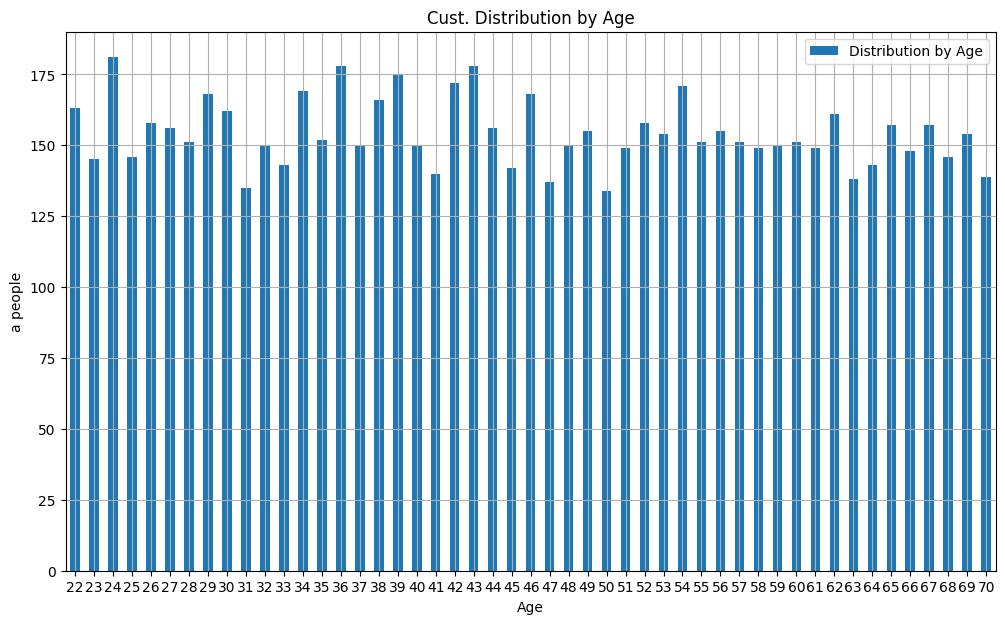

In [12]:
data3 = pd.DataFrame(
                    # Mengklompokkan Berdasarkan umur
                    df_all.groupby(by=["Age"])["Customer ID"]\
                    #customer id diagregatkan dengan menghitung jumlahnya (count)
                    .count()\
                    #Merest nama header
                    .reset_index(name='Distribution by Age')
)
data3.sort_values(\
                  by=['Age'],\
                  ascending=True,\
                  inplace=True)

data3.plot(x='Age',
           y=['Distribution by Age'],
           kind='bar',
           grid=True,
           xlabel = 'Age',
           ylabel = 'a people',
           figsize=(12,7),
           rot = 0,
           title = 'Cust. Distribution by Age',
           table=False,
           sort_columns = False,
           secondary_y = False
           )

<ipython-input-13-efc1ed1cf260>:14: FutureWarning: `sort_columns` is deprecated and will be removed in a future version.
  data4.plot(


<Axes: title={'center': 'Unpaid Cust. Distribution by Age'}, xlabel='Age', ylabel='a people'>

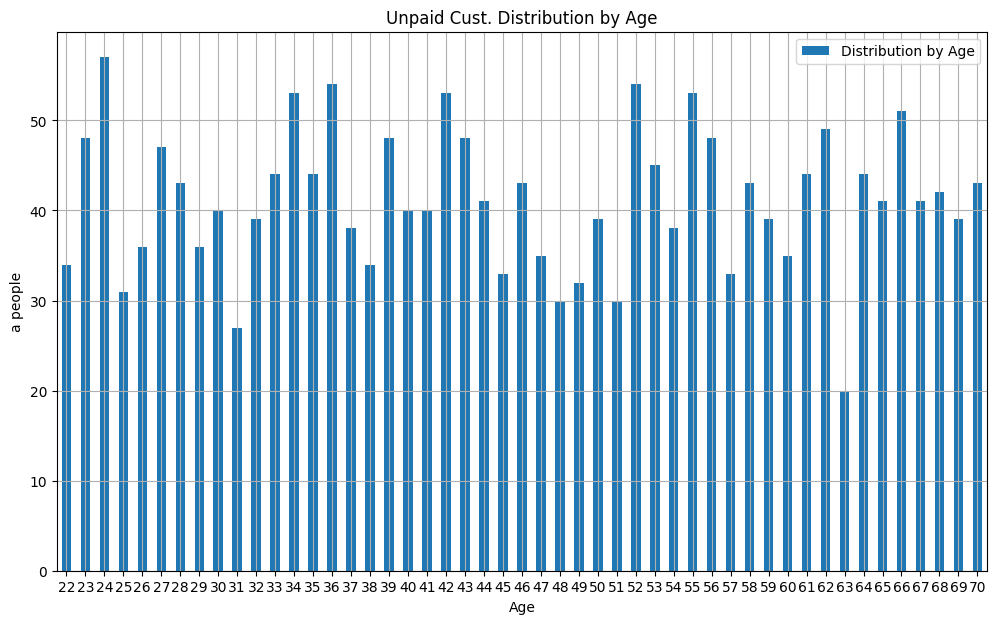

In [13]:
data4 = pd.DataFrame(
                    #mengklompokkan berdsarkan umur
                    df_all[df_all["Unpaid Tagging"]==1].groupby(by=["Age"])["Customer ID"]\
                    #Customer_ID diagregatkan dengan menghitung jumlahnya (count)
                    .count()\
                    #mereset nama header
                    .reset_index(name='Distribution by Age')
)
data4.sort_values(
                  by=["Age"],\
                  ascending = True,\
                  inplace = True
)
data4.plot(
          x='Age',
          y='Distribution by Age',
          kind='bar',
          grid=True,
          xlabel = 'Age',
          ylabel = 'a people',
          figsize = (12,7),
          rot = 0,
          title = 'Unpaid Cust. Distribution by Age',
          table = False,
          sort_columns = False,
          secondary_y = False
)

#Rata-rata saldo nasabah

In [14]:
df_checkbalance = df_all

In [15]:
df_checkbalance['Total Balance'] = df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4']
df_checkbalance['Avg Balance'] = (df_checkbalance['Balance Q1']+df_checkbalance['Balance Q2']+df_checkbalance['Balance Q3']+df_checkbalance['Balance Q4'])/4

In [16]:
data5 = pd.DataFrame(
                    df_checkbalance.groupby(by=["Unpaid Tagging"])["Total Balance"]\
                    .mean()\
                    .reset_index(name='Avg Annual Balance')

)
data5

,Unpaid Tagging,Avg Annual Balance
0,0,1.985924e+08
1,1,2.527238e+08


In [17]:
data6 = pd.DataFrame(
                    df_checkbalance.groupby(by=["Unpaid Tagging"])['Avg Balance']\
                    .mean()\
                    .reset_index(name="Avg Quarterly Balance")
)
data6

,Unpaid Tagging,Avg Quarterly Balance
0,0,4.964809e+07
1,1,6.318095e+07


#Rata rata kepemilikan Produk

In [18]:
df_checkbalance['Avg Product'] = (df_checkbalance["NumOfProducts Q1"]+df_checkbalance["NumOfProducts Q2"]+df_checkbalance["NumOfProducts Q3"]+df_checkbalance["NumOfProducts Q4"])/4

In [19]:
data7 = pd.DataFrame(
                      df_checkbalance.groupby(by=['Unpaid Tagging'])['Avg Product']\
                      .mean()\
                      .reset_index(name="Avg Prduct Owned")
)
data7

,Unpaid Tagging,Avg Prduct Owned
0,0,1.667223
1,1,1.609336


In [20]:
df_all = df_all.drop(columns=["Total Balance","Avg Balance","Avg Product"])

#Data Preparation
Pengecekan Data Duplikat dan Missing Data

In [21]:
df_all.duplicated().sum()

0

In [22]:
df_all.isnull().sum()

Customer ID                 0
Branch Code                 0
City                        0
Age                         0
Avg. Annual Income/Month    0
Balance Q1                  0
NumOfProducts Q1            0
HasCrCard Q1                0
ActiveMember Q1             0
Balance Q2                  0
NumOfProducts Q2            0
HasCrCard Q2                0
ActiveMember Q2             0
Balance Q3                  0
NumOfProducts Q3            0
HasCrCard Q3                0
ActiveMember Q3             0
Balance Q4                  0
NumOfProducts Q4            0
HasCrCard Q4                0
ActiveMember Q4             0
Unpaid Tagging              0
dtype: int64

#Penambahan Variabel Relevan
Rata-rata saldo & perubahan saldo selama periode observasi
Melihat saldo nasabah dalam scope observasi
1. Experiment 1:Rata rata saldo nasabah dalam 1 tahun terakhir & perubahan saldo di Q4 terhadap Q1
2. Experiment 2: Rata rata saldo nasabah dalam 6 bulan terakhir & perubahan saldo di Q4 terhadap Q2

##Experiment 1

In [23]:
df1['Mean Balance'] = (df1['Balance Q1']+df1['Balance Q2']+df1['Balance Q3']+df1['Balance Q4'])/4
df1 ['Delta Balance'] = df1['Balance Q4']-+ df1['Balance Q1']

In [24]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68


##Experiment 2

In [25]:
df2['Num Balance'] = (df2['Balance Q3']+df2['Balance Q4'])/2
df2['Delta Balance'] = df2['Balance Q4']-df2['Balance Q2']

In [26]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging,Num Balance,Delta Balance
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1,593518.09,1187036.18
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1,0.00,0.00
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0,675910.12,1351820.24
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1,0.00,0.00
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0,555048.18,431190.68


#Status Keaktifan
Melihat periode nasabah aktif di dalam scope observasi

1. Experiment 1 ---> Keaktifan nasabah(dalam bulan)di 1 tahun terahir
2. Experiment 2 ---> Keaktifan nasabah(dalam bulan)di 66 bulan terakhir

##Eksperiment 1

In [27]:
df1['Active Month'] = (df1['ActiveMember Q1'] + df1['ActiveMember Q2']+df1['ActiveMember Q3']+df1['ActiveMember Q4'] )*3

In [28]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Month
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6


##Eksperiment 2

In [29]:
df2['Active Month'] = (df2['ActiveMember Q3']+df2['ActiveMember Q4'])*3

In [30]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging,Num Balance,Delta Balance,Active Month
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1,593518.09,1187036.18,3
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1,0.00,0.00,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0,675910.12,1351820.24,3
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1,0.00,0.00,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0,555048.18,431190.68,6


Penambahan / Pengurangan Product Holding
Melihat distribusi kepemilikan produk nasabah dalam periode observasi

##Eksperimen 1

In [31]:
df1['Diff PH'] = df1['NumOfProducts Q4'] - df1['NumOfProducts Q1']

In [32]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Month,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0


##Eksperimen 2

In [33]:
df2['Diff PH'] = df2['NumOfProducts Q4'] - df2['NumOfProducts Q2']

In [34]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging,Num Balance,Delta Balance,Active Month,Diff PH
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1,593518.09,1187036.18,3,0
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1,0.00,0.00,0,0
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0,675910.12,1351820.24,3,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1,0.00,0.00,0,0
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0,555048.18,431190.68,6,0


##Lama Kepemilikan Kredit dalam periode Observasi

In [35]:
def assign_cr1(df):
  if df['HasCrCard Q1'] == 1:
    return 12
  elif df['HasCrCard Q2'] == 1:
    return 9
  elif df['HasCrCard Q3'] == 1:
    return 6
  else:
    return 3
  return np.nan

##Eksperimen 1

In [36]:
df1['vintage_CR'] = df1.apply(assign_cr1,axis =1)

In [37]:
df1.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q1,NumOfProducts Q1,HasCrCard Q1,ActiveMember Q1,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Unpaid Tagging,Mean Balance,Delta Balance,Active Month,Diff PH,vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,1,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1,296759.045,1187036.18,6,0,12
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,0,337955.060,1351820.24,3,0,12
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,1,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0,0.000,0.00,3,0,12
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,0,277524.090,431190.68,6,0,12


##Eksperimen 2

In [38]:
def assign_cr2(df):
  if  df['HasCrCard Q2'] == 1:
    return 9
  elif df['HasCrCard Q3'] == 1:
    return 6
  else:
    return 3
  return np.nan

In [39]:
df2['vintage_CR'] = df2.apply(assign_cr2,axis =1)

In [40]:
df2.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging,Num Balance,Delta Balance,Active Month,Diff PH,vintage_CR
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1,593518.09,1187036.18,3,0,9
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1,0.00,0.00,0,0,9
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0,675910.12,1351820.24,3,0,9
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1,0.00,0.00,0,0,9
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0,555048.18,431190.68,6,0,9


#Penghapusan Variabel
status kepemilikan sudah digantikan dengan lama kepeilikan kartu kredit

In [41]:
df1 = df1.drop(columns = ['HasCrCard Q1', 'HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])
df2 = df2.drop(columns = ['HasCrCard Q2', 'HasCrCard Q3', 'HasCrCard Q4'])

Balance Per Quarter sudah digantikan dengan rata rata saldo dalam periode observasi dan selsih saldo di awal dan akhir periode observasi

In [42]:
df1 = df1.drop(columns = ['Balance Q1','Balance Q2','Balance Q3','Balance Q4'])
df2 = df2.drop (columns = ['Balance Q2','Balance Q3','Balance Q4'])

Jumlah Kepemilikan produk sudah digantikan dengan dluktuasi kepemilikan produk pada periode observasi

In [43]:
df1 = df1.drop(columns = ['NumOfProducts Q1','NumOfProducts Q2','NumOfProducts Q3','NumOfProducts Q4'])
df2 = df2.drop(columns = ['NumOfProducts Q2','NumOfProducts Q3','NumOfProducts Q4'])

Status Keaktifan Nasabah per quarter sudah diantikan dengan status keaktidan dalam bulan

In [44]:
df1 = df1.drop(columns = ['ActiveMember Q1','ActiveMember Q2','ActiveMember Q3','ActiveMember Q4'])
df2 = df2.drop(columns = ['ActiveMember Q2','ActiveMember Q3','ActiveMember Q4'])

#Data Transformation
Pemisahan Variabel Prediktor

In [45]:
predictor1 = df1[df1.columns.difference(['Customer ID','Unpaid Tagging'])]
predictor2 = df2[df2.columns.difference(['Customer ID','Unpaid Tagging'])]

In [46]:
predictor1.head()

,Active Month,Age,Avg. Annual Income/Month,Branch Code,City,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,6,29,33000000,1001,Jakarta,1187036.18,0,296759.045,12
1,3,68,17000000,1005,Jakarta,0.00,0,0.000,12
2,3,25,12000000,1009,Jakarta,1351820.24,0,337955.060,12
3,3,42,19000000,1008,Jakarta,0.00,0,0.000,12
4,6,43,29000000,1009,Jakarta,431190.68,0,277524.090,12


In [47]:
predictor2.head()

,Active Month,ActiveMember Q5,Age,Avg. Annual Income/Month,Balance Q5,Branch Code,City,Delta Balance,Diff PH,HasCrCard Q5,Num Balance,NumOfProducts Q5,vintage_CR
0,3,1,29,33000000,1305739.798,1001,Jakarta,1187036.18,0,1,593518.09,1,9
1,0,0,68,17000000,0.000,1005,Jakarta,0.00,0,1,0.00,2,9
2,3,1,25,12000000,1622184.288,1009,Jakarta,1351820.24,0,1,675910.12,2,9
3,0,0,42,19000000,0.000,1008,Jakarta,0.00,0,1,0.00,4,9
4,6,0,43,29000000,431190.680,1009,Jakarta,431190.68,0,1,555048.18,3,9


#Melakukan Encoding untuk Data Category

variabel Category:
1.Branch Code
2.City
untuk branch code perlu diubah menjadi string agar dianggap sebagai data category

In [48]:
predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)

<ipython-input-48-b9748522fe9d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1['Branch Code'] = predictor1['Branch Code'].astype(str)
<ipython-input-48-b9748522fe9d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2['Branch Code'] = predictor2['Branch Code'].astype(str)


ubah variable branch code dari angka menjadi string

In [49]:
predictor1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Month              7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [50]:
predictor2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Month              7561 non-null   int64  
 1   ActiveMember Q5           7561 non-null   int64  
 2   Age                       7561 non-null   int64  
 3   Avg. Annual Income/Month  7561 non-null   int64  
 4   Balance Q5                7561 non-null   float64
 5   Branch Code               7561 non-null   object 
 6   City                      7561 non-null   object 
 7   Delta Balance             7561 non-null   float64
 8   Diff PH                   7561 non-null   int64  
 9   HasCrCard Q5              7561 non-null   int64  
 10  Num Balance               7561 non-null   float64
 11  NumOfProducts Q5          7561 non-null   int64  
 12  vintage_CR                7561 non-null   int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 768.0+ KB


In [51]:
predictor1 = pd.get_dummies(predictor1)
predictor2 = pd.get_dummies(predictor2)

In [52]:
predictor1.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1187036.18,0,296759.045,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3,68,17000000,0.00,0,0.000,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,25,12000000,1351820.24,0,337955.060,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,3,42,19000000,0.00,0,0.000,12,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6,43,29000000,431190.68,0,277524.090,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


jadi kolom yang string seperti branch_code dan city menjadi di encode

In [53]:
predictor2.head()

,Active Month,ActiveMember Q5,Age,Avg. Annual Income/Month,Balance Q5,Delta Balance,Diff PH,HasCrCard Q5,Num Balance,NumOfProducts Q5,vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,3,1,29,33000000,1305739.798,1187036.18,0,1,593518.09,1,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,68,17000000,0.000,0.00,0,1,0.00,2,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,1,25,12000000,1622184.288,1351820.24,0,1,675910.12,2,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,42,19000000,0.000,0.00,0,1,0.00,4,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6,0,43,29000000,431190.680,431190.68,0,1,555048.18,3,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


dilihat di atas masih ada kolom yang perlu di drop

In [54]:
predictor2 = predictor2.drop(columns = ['ActiveMember Q5','Balance Q5','HasCrCard Q5','NumOfProducts Q5'])

In [55]:
predictor2.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Num Balance,vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,3,29,33000000,1187036.18,0,593518.09,9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,68,17000000,0.00,0,0.00,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,25,12000000,1351820.24,0,675910.12,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,42,19000000,0.00,0,0.00,9,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6,43,29000000,431190.68,0,555048.18,9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [56]:
predictor1.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1187036.18,0,296759.045,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,3,68,17000000,0.00,0,0.000,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,3,25,12000000,1351820.24,0,337955.060,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,3,42,19000000,0.00,0,0.000,12,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6,43,29000000,431190.68,0,277524.090,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [57]:
predname = predictor1.columns
predname_num = predictor1.columns[0:7]
predname_cat = predictor1.columns[7:31]

In [58]:
predname2 = predictor2.columns
predname_num2 = predictor2.columns[0:7]
predname_cat2 = predictor2.columns[7:31]

predname menyimpan data indeks,
num kita mengambil predictor sifat numerik 0:7 artinya 0 kolom ke 1 , 7 itu kolom ke 6 karna 0 itu 1
kenapa 0:7 karena dia memotong -1
jadi kalo di hitung harusny sampai branch code(8), tapi karena -1 maka dia sampe vintage_Cr

In [59]:
predname

Index(['Active Month', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'vintage_CR', 'Branch Code_1001',
       'Branch Code_1002', 'Branch Code_1003', 'Branch Code_1004',
       'Branch Code_1005', 'Branch Code_1006', 'Branch Code_1007',
       'Branch Code_1008', 'Branch Code_1009', 'Branch Code_1011',
       'Branch Code_1012', 'Branch Code_1013', 'Branch Code_1014',
       'Branch Code_1015', 'Branch Code_1021', 'Branch Code_1022',
       'Branch Code_1023', 'Branch Code_1024', 'City_Bandung', 'City_Jakarta',
       'City_Surabaya'],
      dtype='object')

In [60]:
predname_num

Index(['Active Month', 'Age', 'Avg. Annual Income/Month', 'Delta Balance',
       'Diff PH', 'Mean Balance', 'vintage_CR'],
      dtype='object')

In [61]:
predname_cat

Index(['Branch Code_1001', 'Branch Code_1002', 'Branch Code_1003',
       'Branch Code_1004', 'Branch Code_1005', 'Branch Code_1006',
       'Branch Code_1007', 'Branch Code_1008', 'Branch Code_1009',
       'Branch Code_1011', 'Branch Code_1012', 'Branch Code_1013',
       'Branch Code_1014', 'Branch Code_1015', 'Branch Code_1021',
       'Branch Code_1022', 'Branch Code_1023', 'Branch Code_1024',
       'City_Bandung', 'City_Jakarta', 'City_Surabaya'],
      dtype='object')

In [62]:
X1_num = predictor1[predname_num]
X2_num = predictor2[predname_num2]
X1_cat = predictor1[predname_cat]
X2_cat = predictor2[predname_cat2]

#Standardisasi Data Numerik

In [63]:
from sklearn.preprocessing import StandardScaler
pt = StandardScaler()
X1_num = pd.DataFrame(pt.fit_transform(X1_num))
X1_num.head()

,0,1,2,3,4,5,6
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [64]:
X1_num.columns = predname_num
X1_num.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [65]:
X2_num = pd.DataFrame(pt.fit_transform(X2_num))
X2_num.head()

,0,1,2,3,4,5,6
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [66]:
X2_num.columns = predname_num2
X2_num.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Num Balance,vintage_CR
0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


#Menggabungkan Dataset Predictor

In [67]:
X1 = pd.concat([X1_cat,X1_num],axis = 1)
X2 = pd.concat([X2_cat,X2_num],axis = 1)

In [68]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [69]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Num Balance,vintage_CR
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [70]:
y1 = df1['Unpaid Tagging']
y2 = df2['Unpaid Tagging']

#Mempersiapkan Dataset untuk validation
import Data

In [71]:
df1_val = pd.read_csv(path2)
df2_val = pd.read_csv(path2)

In [72]:
df1_val.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0


In [73]:
df2_val.head()

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Balance Q2,NumOfProducts Q2,HasCrCard Q2,ActiveMember Q2,Balance Q3,NumOfProducts Q3,HasCrCard Q3,ActiveMember Q3,Balance Q4,NumOfProducts Q4,HasCrCard Q4,ActiveMember Q4,Balance Q5,NumOfProducts Q5,HasCrCard Q5,ActiveMember Q5,Unpaid Tagging
0,15565701,1001,Jakarta,29,33000000,0.0,1,1,0,0.00,1,1,0,1187036.18,1,1,1,1305739.798,1,1,1,1
1,15565878,1005,Jakarta,68,17000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,2,1,0,1
2,15566091,1009,Jakarta,25,12000000,0.0,2,1,0,0.00,2,1,0,1351820.24,2,1,1,1622184.288,2,1,1,0
3,15566292,1008,Jakarta,42,19000000,0.0,2,1,0,0.00,2,1,0,0.00,2,1,0,0.000,4,1,0,1
4,15566312,1009,Jakarta,43,29000000,0.0,2,1,0,678905.68,2,1,1,431190.68,2,1,1,431190.680,3,1,0,0


#Penambahan Variabel Relevan
Rata rata Balance & Perubahan Saldo

In [74]:
df1_val['Mean Balance'] = (df1_val['Balance Q2']+df1_val['Balance Q3']+df1_val['Balance Q4']+df1_val['Balance Q5'])/4
df2_val['Mean Balance'] = (df2_val['Balance Q4']+df1_val['Balance Q5'])/2

In [75]:
df1_val['Delta Balance'] = df1_val['Balance Q5']-df1_val['Balance Q2']
df2_val['Delta Balance'] = df2_val['Balance Q5']-df2_val['Balance Q3']

#Status Keaktifan

In [76]:
df1_val['Active Month'] = (df1_val['ActiveMember Q2']+df1_val['ActiveMember Q3']+df1_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3
df2_val['Active Month'] = (df2_val['ActiveMember Q4']+df1_val['ActiveMember Q5'])*3

#Penambahan/Pengurangan Product Holding

In [77]:
df1_val['Diff PH'] = df1_val['NumOfProducts Q5']-df1_val['NumOfProducts Q2']
df2_val['Diff PH'] = df2_val['NumOfProducts Q5']-df1_val['NumOfProducts Q3']

#Lama Kepemilikan Kartu Kredit

In [78]:
def assign_cr3(df):
  if df['HasCrCard Q2'] == 1:
    return 12
  elif df['HasCrCard Q3'] == 1:
    return 9
  elif df['HasCrCard Q4'] == 1:
    return 6
  else:
    return 3
  return np.nan

In [79]:
df1_val['vintage_CR'] = df1_val.apply(assign_cr3,axis = 1)
df2_val['vintage_CR'] = df2_val.apply(assign_cr3,axis = 1)

#Penghapusan Variabel

In [80]:
df1_val = df1_val.drop(columns = ['HasCrCard Q5','HasCrCard Q4','HasCrCard Q3','HasCrCard Q2','Balance Q5','Balance Q4','Balance Q3','Balance Q2','NumOfProducts Q5','NumOfProducts Q4','NumOfProducts Q3','NumOfProducts Q2','ActiveMember Q5','ActiveMember Q4','ActiveMember Q3','ActiveMember Q2'])
df2_val = df2_val.drop(columns = ['HasCrCard Q5','HasCrCard Q4','HasCrCard Q3','HasCrCard Q2','Balance Q5','Balance Q4','Balance Q3','Balance Q2','NumOfProducts Q5','NumOfProducts Q4','NumOfProducts Q3','NumOfProducts Q2','ActiveMember Q5','ActiveMember Q4','ActiveMember Q3','ActiveMember Q2'])

In [81]:
df1_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Month,Diff PH,vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,6.231940e+05,1.305740e+06,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,7.435011e+05,1.622184e+06,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,3.853218e+05,4.311907e+05,6,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.647607e+07,1.365946e+07,9,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.234332e+08,5.441502e+07,9,2,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.247047e+05,2.996062e+05,3,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.243379e+07,1.169147e+07,9,0,6


In [82]:
df2_val.head(10)

,Customer ID,Branch Code,City,Age,Avg. Annual Income/Month,Unpaid Tagging,Mean Balance,Delta Balance,Active Month,Diff PH,vintage_CR
0,15565701,1001,Jakarta,29,33000000,1,1.246388e+06,1.305740e+06,6,0,12
1,15565878,1005,Jakarta,68,17000000,1,0.000000e+00,0.000000e+00,0,0,12
2,15566091,1009,Jakarta,25,12000000,0,1.487002e+06,1.622184e+06,6,0,12
3,15566292,1008,Jakarta,42,19000000,1,0.000000e+00,0.000000e+00,0,2,12
4,15566312,1009,Jakarta,43,29000000,0,4.311907e+05,-2.477150e+05,3,1,12
5,15566495,1005,Jakarta,27,15000000,0,5.990946e+07,1.338732e+07,6,0,12
6,15566543,1003,Jakarta,68,26000000,0,1.370369e+08,5.481477e+07,3,1,12
7,15566594,1008,Jakarta,61,24000000,1,0.000000e+00,0.000000e+00,0,0,12
8,15566689,1003,Jakarta,43,38000000,0,2.996062e+05,0.000000e+00,0,1,12
9,15566958,1005,Jakarta,70,23000000,0,8.535666e+07,1.191023e+07,3,0,6


#Pemilihan Variabel Prediktor

In [83]:
predictor1_val = df1_val[df1_val.columns.difference(['Customer ID','Unpaid Tagging'])]
predictor2_val = df2_val[df2_val.columns.difference(['Customer ID','Unpaid Tagging'])]

In [84]:
predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)

<ipython-input-84-2d4929c2aa9e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor1_val['Branch Code'] = predictor1_val['Branch Code'].astype(str)
<ipython-input-84-2d4929c2aa9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictor2_val['Branch Code'] = predictor2_val['Branch Code'].astype(str)


In [85]:
predictor1_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Month              7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


In [86]:
predictor2_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7561 entries, 0 to 7560
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Active Month              7561 non-null   int64  
 1   Age                       7561 non-null   int64  
 2   Avg. Annual Income/Month  7561 non-null   int64  
 3   Branch Code               7561 non-null   object 
 4   City                      7561 non-null   object 
 5   Delta Balance             7561 non-null   float64
 6   Diff PH                   7561 non-null   int64  
 7   Mean Balance              7561 non-null   float64
 8   vintage_CR                7561 non-null   int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 531.8+ KB


##Encode

In [87]:
predictor1_val = pd.get_dummies(predictor1_val)
predictor2_val = pd.get_dummies(predictor2_val)

In [88]:
predictor1_val.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1305739.798,0,623193.9945,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,68,17000000,0.000,0,0.0000,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,6,25,12000000,1622184.288,0,743501.1320,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,42,19000000,0.000,2,0.0000,12,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,6,43,29000000,431190.680,1,385321.7600,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [89]:
predictor2_val.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya
0,6,29,33000000,1305739.798,0,1246387.989,12,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,68,17000000,0.000,0,0.000,12,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,6,25,12000000,1622184.288,0,1487002.264,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,42,19000000,0.000,2,0.000,12,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,3,43,29000000,-247715.000,1,431190.680,12,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [90]:
X1_num_val = predictor1_val[predname_num]
X2_num_val = predictor2_val[predname_num]
X1_cat_val = predictor1_val[predname_cat]
X2_cat_val = predictor2_val[predname_cat]

#Standardisasi Val

In [91]:
X1_num_val = pd.DataFrame(pt.fit_transform(X1_num_val))
X1_num_val.columns = predname_num

X2_num_val = pd.DataFrame(pt.fit_transform(X2_num_val))
X2_num_val.columns = predname_num

In [92]:
X1_num_val.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,-0.086964,-1.185374,0.663649,-0.373514,-0.517011,-0.942483,0.296502
1,-1.692667,1.580668,-0.680854,-0.497238,-0.517011,-0.953367,0.296502
2,-0.086964,-1.469071,-1.101011,-0.343530,-0.517011,-0.940382,0.296502
3,-1.692667,-0.263360,-0.512791,-0.497238,2.724384,-0.953367,0.296502
4,-0.086964,-0.192436,0.327524,-0.456381,1.103686,-0.946638,0.296502


In [93]:
X2_num_val.head()

,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,1.254342,-1.185374,0.663649,-0.367984,-0.419420,-0.930631,0.296502
1,-1.357273,1.580668,-0.680854,-0.491518,-0.419420,-0.951848,0.296502
2,1.254342,-1.469071,-1.101011,-0.338045,-0.419420,-0.926535,0.296502
3,-1.357273,-0.263360,-0.512791,-0.491518,3.246748,-0.951848,0.296502
4,-0.051466,-0.192436,0.327524,-0.514954,1.413664,-0.944508,0.296502


In [94]:
X1_val = pd.concat([X1_cat_val,X1_num_val],axis = 1)
X2_val = pd.concat([X2_cat_val,X2_num_val],axis = 1)

In [95]:
X1_val.head(10)

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.086964,-1.185374,0.663649,-0.373514,-0.517011,-0.942483,0.296502
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.692667,1.580668,-0.680854,-0.497238,-0.517011,-0.953367,0.296502
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.086964,-1.469071,-1.101011,-0.343530,-0.517011,-0.940382,0.296502
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.692667,-0.263360,-0.512791,-0.497238,2.724384,-0.953367,0.296502
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.086964,-0.192436,0.327524,-0.456381,1.103686,-0.946638,0.296502
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.715888,-1.327223,-0.848916,0.797050,-0.517011,0.032919,0.296502
6,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.715888,1.580668,0.075429,4.658805,2.724384,1.202243,0.296502
7,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.692667,1.084199,-0.092634,-0.497238,-0.517011,-0.953367,0.296502
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.889816,-0.192436,1.083807,-0.468849,1.103686,-0.949443,0.296502
9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0.715888,1.722516,-0.176665,0.610575,-0.517011,0.486239,-3.372654


In [96]:
X2_val.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.254342,-1.185374,0.663649,-0.367984,-0.419420,-0.930631,0.296502
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.357273,1.580668,-0.680854,-0.491518,-0.419420,-0.951848,0.296502
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.254342,-1.469071,-1.101011,-0.338045,-0.419420,-0.926535,0.296502
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.357273,-0.263360,-0.512791,-0.491518,3.246748,-0.951848,0.296502
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.051466,-0.192436,0.327524,-0.514954,1.413664,-0.944508,0.296502


In [97]:
y1_val = df1_val['Unpaid Tagging']
y2_val = df2_val['Unpaid Tagging']

#Pengecekan Korelasi
variabel yang berkorelasi lebih dari 0.7 akan di drop.

In [98]:
corrtest1 = X1.corr().abs()
corrtest2 = X2.corr().abs()

In [99]:
corrtest1

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.000365,0.010394,0.003603,0.001462,0.003888,0.009732,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.007664,0.006371,0.016078,0.004592,0.003957,0.005634,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.018168,0.013724,0.001937,0.008577,0.004227,0.001776,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.001120,0.008420,0.002095,0.015427,0.001172,0.013269,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.011655,0.001335,0.008829,0.010599,0.001569,0.007520,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,0.038095,0.037889,0.036740,0.036048,0.061989,0.060229,0.061056,0.062841,0.094442,0.281983,0.162551,0.006704,0.004534,0.007488,0.000112,0.017499,0.004003,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,0.038591,0.038383,0.037219,0.036517,0.062796,0.061013,0.061851,0.063659,0.095672,0.285654,0.164668,0.010148,0.011408,0.024003,0.002511,0.018648,0.006408,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,0.038886,0.038676,0.037503,0.036796,0.063276,0.061479,0.062323,0.064146,0.096403,0.287836,0.165926,0.000426,0.005992,0.000678,0.003350,0.006413,0.001808,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.002480,0.002933,0.012510,0.001391,0.012129,0.005874,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,0.055410,0.055110,0.053439,0.052431,0.090163,0.087603,0.088806,0.091403,0.409857,0.137270,0.236432,0.001055,0.011252,0.016018,0.025531,0.004062,0.005530,0.020666


In [100]:
corrtest2

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Num Balance,vintage_CR
Branch Code_1001,1.000000,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,0.028707,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.007562,0.010394,0.003603,0.010657,0.002625,0.009749,0.020774
Branch Code_1002,0.028917,1.000000,0.029128,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.006371,0.016078,0.001174,0.000411,0.005640,0.034256
Branch Code_1003,0.028917,0.029128,1.000000,0.029889,0.029545,0.027842,0.028204,0.028420,0.028917,0.040496,0.039855,0.039639,0.038437,0.037713,0.064852,0.063011,0.063876,0.065744,0.098804,0.295007,0.170060,0.011636,0.013724,0.001937,0.016142,0.007450,0.001736,0.021341
Branch Code_1004,0.029673,0.029889,0.029889,1.000000,0.030318,0.028570,0.028941,0.029163,0.029673,0.041555,0.040897,0.040676,0.039442,0.038699,0.066548,0.064658,0.065546,0.067463,0.101388,0.302721,0.174506,0.007556,0.008420,0.002095,0.023383,0.007340,0.013205,0.003376
Branch Code_1005,0.029331,0.029545,0.029545,0.030318,1.000000,0.028241,0.028608,0.028827,0.029331,0.041076,0.040426,0.040208,0.038988,0.038253,0.065782,0.063914,0.064792,0.066686,0.100221,0.299236,0.172498,0.009181,0.001335,0.008829,0.010614,0.003334,0.007493,0.002246
Branch Code_1006,0.027640,0.027842,0.027842,0.028570,0.028241,1.000000,0.026959,0.027165,0.027640,0.038708,0.038095,0.037889,0.036740,0.036048,0.061989,0.060229,0.061056,0.062841,0.094442,0.281983,0.162551,0.002050,0.004534,0.007488,0.007557,0.002061,0.004017,0.008669
Branch Code_1007,0.028000,0.028204,0.028204,0.028941,0.028608,0.026959,1.000000,0.027518,0.028000,0.039212,0.038591,0.038383,0.037219,0.036517,0.062796,0.061013,0.061851,0.063659,0.095672,0.285654,0.164668,0.013401,0.011408,0.024003,0.002299,0.018009,0.006425,0.003749
Branch Code_1008,0.028214,0.028420,0.028420,0.029163,0.028827,0.027165,0.027518,1.000000,0.028214,0.039511,0.038886,0.038676,0.037503,0.036796,0.063276,0.061479,0.062323,0.064146,0.096403,0.287836,0.165926,0.005226,0.005992,0.000678,0.009595,0.012922,0.001792,0.016428
Branch Code_1009,0.028707,0.028917,0.028917,0.029673,0.029331,0.027640,0.028000,0.028214,1.000000,0.040203,0.039566,0.039353,0.038159,0.037440,0.064383,0.062555,0.063414,0.065268,0.098089,0.292872,0.168829,0.002926,0.002933,0.012510,0.002003,0.022414,0.005889,0.014582
Branch Code_1011,0.040203,0.040496,0.040496,0.041555,0.041076,0.038708,0.039212,0.039511,0.040203,1.000000,0.055410,0.055110,0.053439,0.052431,0.090163,0.087603,0.088806,0.091403,0.409857,0.137270,0.236432,0.002436,0.011252,0.016018,0.021118,0.012993,0.005449,0.020666


In [101]:
# Membuang nilai redundan pada matriks
upper = corrtest1.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))

# Mencari nilai yang berkorelasi di atas 0.7
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

# menghapus colom yang berkrelasi diatas 0.7
X1 = X1.drop(to_drop,axis=1)
X1_val = X1_val.drop(to_drop,axis=1)

In [102]:
X1.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.135176,-1.185374,0.663649,1.964593,-0.531491,-0.947970,0.296502
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.013239,1.580668,-0.680854,-0.319523,-0.531491,-0.953281,0.296502
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-1.013239,-1.469071,-1.101011,2.281673,-0.531491,-0.947232,0.296502
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.013239,-0.263360,-0.512791,-0.319523,-0.531491,-0.953281,0.296502
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.135176,-0.192436,0.327524,0.510182,-0.531491,-0.948314,0.296502


In [103]:
# Membuang nilai redundan pada matriks
upper2 = corrtest2.where(np.triu(np.ones(corrtest1.shape), k=1).astype(bool))

# Mencari nilai yang berkorelasi di atas 0.7
to_drop2 = [column for column in upper2.columns if any(upper2[column] > 0.7)]

# menghapus colom yang berkrelasi diatas 0.7
X2 = X2.drop(to_drop2,axis=1)
X2_val = X2_val.drop(to_drop2,axis=1)

In [104]:
X2.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Num Balance,vintage_CR
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.165835,-1.185374,0.663649,2.641819,-0.440014,-0.944440,0.296502
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.471959,1.580668,-0.680854,-0.233476,-0.440014,-0.955071,0.296502
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.165835,-1.469071,-1.101011,3.040967,-0.440014,-0.942964,0.296502
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.471959,-0.263360,-0.512791,-0.233476,-0.440014,-0.955071,0.296502
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.140289,-0.192436,0.327524,0.810974,-0.440014,-0.945129,0.296502


In [141]:
X2_val.head()

,Branch Code_1001,Branch Code_1002,Branch Code_1003,Branch Code_1004,Branch Code_1005,Branch Code_1006,Branch Code_1007,Branch Code_1008,Branch Code_1009,Branch Code_1011,Branch Code_1012,Branch Code_1013,Branch Code_1014,Branch Code_1015,Branch Code_1021,Branch Code_1022,Branch Code_1023,Branch Code_1024,City_Bandung,City_Jakarta,City_Surabaya,Active Month,Age,Avg. Annual Income/Month,Delta Balance,Diff PH,Mean Balance,vintage_CR
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1.254342,-1.185374,0.663649,-0.367984,-0.419420,-0.930631,0.296502
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.357273,1.580668,-0.680854,-0.491518,-0.419420,-0.951848,0.296502
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1.254342,-1.469071,-1.101011,-0.338045,-0.419420,-0.926535,0.296502
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,-1.357273,-0.263360,-0.512791,-0.491518,3.246748,-0.951848,0.296502
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,-0.051466,-0.192436,0.327524,-0.514954,1.413664,-0.944508,0.296502


#Splitting Train-Test Data

In [105]:
y1.value_counts()

0    5542
1    2019
Name: Unpaid Tagging, dtype: int64

In [106]:
y2.value_counts()

0    4852
1    2709
Name: Unpaid Tagging, dtype: int64

In [107]:
from sklearn.model_selection import train_test_split

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, stratify=y1, random_state=30)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, stratify=y2, random_state=30)

#MODELING
Pembanungan model akan menggunakan 3 algoritma:
1. Logistic Regression
2. Gradient_Boosting
3. Random Forest

#Logistic Regression
Melakukan Definisi Hyperparameter


In [108]:
penalty = ['l2']
tol = [0.001, 0.0001, 0.00001]
C = [100.0,10.0,1.00,0.1,0.01,0.001]
fit_intercept = [True,False]
intercept_scaling = [1.0,0.75,0.5,0.25]
class_weight = ['balanced',None]
solver = ['newton-cg','sag','lbfgs','saga']
max_iter=[14000]
param_distribution = dict(penalty=penalty,tol=tol,C=C,fit_intercept=fit_intercept,intercept_scaling=intercept_scaling,
                          class_weight=class_weight,solver=solver,max_iter=max_iter)

Melakukan pencarian hypermeter terbaik

In [109]:
from sklearn.model_selection import GridSearchCV

##Eksperimen 1

In [110]:
import time

#cv = cross validation
logreg = LogisticRegression()
grid = GridSearchCV(estimator=logreg, param_grid = param_distribution, scoring ='recall',cv = 5, n_jobs=-1)

start_time = time.time()
grid_result = grid.fit(X1_train, y1_train)
#Summarize result
print("Best: %f using %s" % (grid_result.best_score_,grid_result.best_params_))
print("Execution time:" + str((time.time() - start_time))+ ' s')

Best: 0.418269 using {'C': 100.0, 'class_weight': 'balanced', 'fit_intercept': True, 'intercept_scaling': 0.75, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'sag', 'tol': 0.001}
Execution time:815.7952620983124 s


##Eksperimen 2

In [111]:
grid2 = GridSearchCV(estimator=logreg,param_grid = param_distribution, scoring='recall',cv= 5, n_jobs=-1)
start_time = time.time()
grid_result2 = grid2.fit(X2_train, y2_train)
#summarize result
print("Best: %f using %s" % (grid_result2.best_score_,grid_result2.best_params_))
print("Execution time:" + str((time.time() - start_time))+ ' s')

Best: 0.323833 using {'C': 100.0, 'class_weight': 'balanced', 'fit_intercept': True, 'intercept_scaling': 0.25, 'max_iter': 14000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
Execution time:1073.870280265808 s


#Gradient Boosting

In [112]:
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, make_scorer,accuracy_score,precision_score,recall_score,f1_score

In [113]:
gbparameter = {
                'max_depth':[5,10,15],
                'gamma':[0.1, 0.1, 0.2, 0.3],
                'n_estimators':[25,50,75,100],
                'learning_rate':[0.05, 0.1, 0.2, 0.3],
                'scale_pos_weight':[1,4]
}
score = {
          'accuracy':make_scorer(accuracy_score),
          'precision':make_scorer(precision_score),
          'recall':make_scorer(recall_score),
          'f1':make_scorer(f1_score)
}

Gamma: Nilai minimal loss reduction yang dibutuhkan pada saat pemecahan cabang.  Semakin besar nilai gamma yang ditetapkan, model yang dibangun akan lebih konservatif dan memungkinkan terjadinya underfitting.

learning_rate:tingkat penyesuaian bobot fitur.  Dalam membangun model, setiap iterasi menghasilkan bobot untuk fitur-fitur yang dimiliki. Learning_rate berguna untuk membantu menyusutkan nilai bobot tersebut agar model yang dibangun tidak mengalami overfitting.

Scale_pos_weight:pengaturan bobot antara kelas positif(churn) dengan kelas negatif(not churn).  Hyperparameter ini sangat berguna ketika dataset yang digunakan merupakan imbalance datasets.  Nilai yang biasa digunakan yaitu jumlah dari majority class dibagi dengan jumlah minority class.

##Eksperimen 1

In [114]:
xgb= XGBClassifier()

In [115]:
GB_Grid = GridSearchCV(estimator=xgb,param_grid=gbparameter, cv=5, refit= "recall", verbose=0, n_jobs=-1,scoring=score)

In [116]:
start_time = time.time()
GB_result = GB_Grid.fit(X1_train, y1_train)
# Summarize result
print("Best: %f using %s" % (GB_result.best_score_, GB_result.best_params_))
print("Execution time: " + str((time.time() - start_time)) + ' s')


Best: 0.829454 using {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 4}
Execution time: 314.53110933303833 s


In [117]:
GB_Grid2 = GridSearchCV(estimator=xgb,param_grid=gbparameter,cv=5,refit='recall',verbose=0,n_jobs=-1,scoring=score)

In [118]:
start_time = time.time()
GB2_result = GB_Grid2.fit(X2_train,y2_train)
#Summarize result
print("Best: %f using %s" % (GB2_result.best_score_,GB2_result.best_params_))
print("Execution:"+ str((time.time() - start_time))+ ' s')

Best: 0.991561 using {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 25, 'scale_pos_weight': 4}
Execution:333.3173186779022 s


#Random Forest

In [119]:
from sklearn.ensemble import RandomForestClassifier

In [120]:
rfparameter = {
              'max_depth':[5,10,15,20],
              'max_features':['auto','sqrt','log2'],
              'n_estimators':[25,50,75,100,125],
              'min_samples_split':[2,3,5,7]
}
score = {
          'accuracy':make_scorer(accuracy_score),
          'precision':make_scorer(precision_score),
          'recall':make_scorer(recall_score),
          'f1':make_scorer(f1_score)
}

Max_depth: jumlah maksimal pemecahan cabang atau level dalam satu pohon, semakin besar nilai max_depth yang ditetapkan, model akan semakin presisi dalam menggolongkan data ke suatu kelas.  Akan tetapi semakin besar nilai max_depth juga akan membuat model overfitting

Max_feature:jumlah maksimal fitur yang dipertimbangkan ketika melakukan pemecahan cabang (splitting mode). sama halnya dengan max_depth, semakin banyak jumlah fitur yang dipertimbangkan dalam pemecahan cabang, akan semakin detail hasil yang didapatkan tetapi juga akan membuat model overfitting terhadap data training nya.

N_estimators:jumlah pohon yang akan dibangun, semakin banyak pohon, tingkat akurasi yang didapatkan menjadi lebih baik mengingat random forest menggunakan konsep majority vote dalam melakukan identifikasi.  Akan tetapi semakin banyak pohon yang dibangun waktu komputasi dibutuhkan juga akan semakin tinggi.

Min_sampel_split:jumlah sampel data minimal pada sebuah internal node. Nilai yang besar dapat membuat model yang dibangun lebih konservatif. Akan tetapi, jika terlalu besar dapat menyebabkan model yang dibangun underfitting

##Eksperimen 1

In [121]:
RFC=RandomForestClassifier()

In [122]:
RF_Grid = GridSearchCV(estimator=RFC,param_grid=rfparameter, cv=5,refit="recall",verbose=0,n_jobs=-1,scoring=score)

In [123]:
start_time = time.time()
RF_result = RF_Grid.fit(X1_train,y1_train)
#Summarize result
print("Best: %f Using %s" % (RF_result.best_score_,RF_result.best_params_))
print("Execution time:" + str((time.time() - start_time))+ ' s')

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best: 0.326251 Using {'max_depth': 20, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 25}
Execution time:395.543576002121 s


##Eksperimen 2

In [124]:
RF_Grid2 = GridSearchCV(estimator =RFC,param_grid=rfparameter, cv=5,refit="recall",verbose=0,n_jobs=-1,scoring=score)

In [125]:
start_time = time.time()
RF_result2 = RF_Grid2.fit(X2_train,y2_train)
#Summarize result
print("Best: %f Using %s" % (RF_result2.best_score_,RF_result2.best_params_))
print("Execution time:" + str((time.time() - start_time))+ ' s')

Best: 0.220453 Using {'max_depth': 20, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 25}
Execution time:418.2101671695709 s


#Evaluation

##Logistic Regression

##Eksperimen 1

In [126]:
y1_pred = grid.predict(X1_test)

In [127]:
from sklearn import metrics
print("Accuracy:", metrics.accuracy_score(y1_test,y1_pred))
print("Recall:",metrics.recall_score(y1_test,y1_pred))
metrics.completeness_score

Accuracy: 0.7778757161745262
Recall: 0.43564356435643564


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [128]:
y1_pred_val=grid.predict(X1_val)

In [129]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val,y1_pred_val))
print("Recall:",metrics.recall_score(y1_val,y1_pred_val))
metrics.completeness_score

Accuracy: 0.6411850284353922
Recall: 0.22296050203026946


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

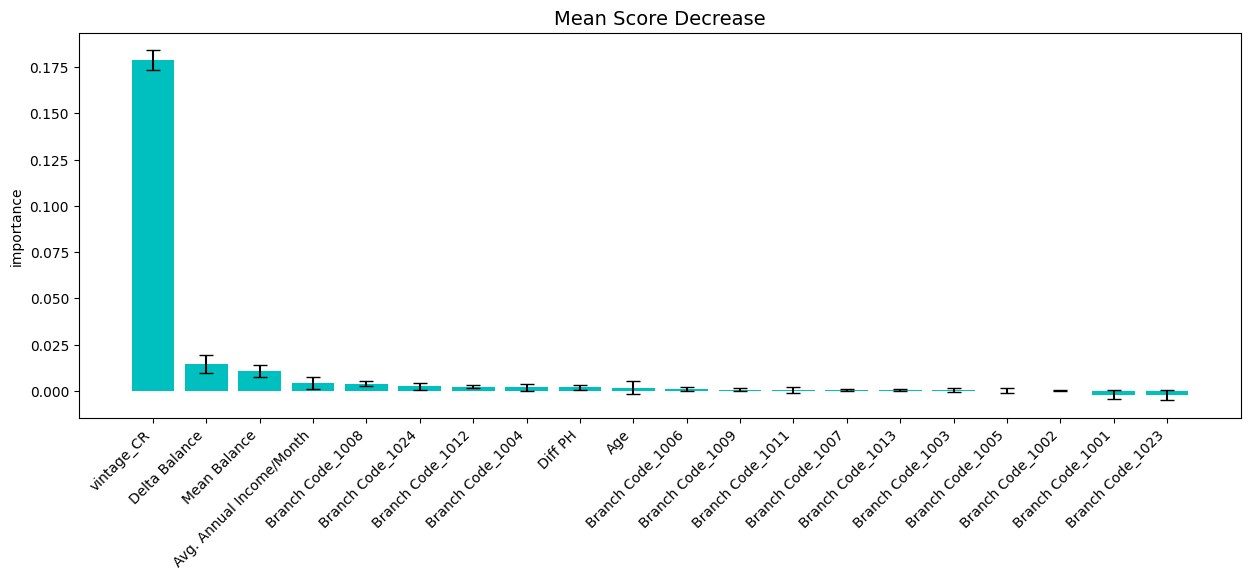

In [130]:
from jcopml.feature_importance import mean_score_decrease
df_imp1 = mean_score_decrease(X1_train,y1_train,grid,plot=True, topk=20)

##Eksperimen 2

In [131]:
print(X2_test.columns)


Index(['Branch Code_1001', 'Branch Code_1002', 'Branch Code_1003',
       'Branch Code_1004', 'Branch Code_1005', 'Branch Code_1006',
       'Branch Code_1007', 'Branch Code_1008', 'Branch Code_1009',
       'Branch Code_1011', 'Branch Code_1012', 'Branch Code_1013',
       'Branch Code_1014', 'Branch Code_1015', 'Branch Code_1021',
       'Branch Code_1022', 'Branch Code_1023', 'Branch Code_1024',
       'City_Bandung', 'City_Jakarta', 'City_Surabaya', 'Active Month', 'Age',
       'Avg. Annual Income/Month', 'Delta Balance', 'Diff PH', 'Num Balance',
       'vintage_CR'],
      dtype='object')


In [132]:
print(X2_train.columns)


Index(['Branch Code_1001', 'Branch Code_1002', 'Branch Code_1003',
       'Branch Code_1004', 'Branch Code_1005', 'Branch Code_1006',
       'Branch Code_1007', 'Branch Code_1008', 'Branch Code_1009',
       'Branch Code_1011', 'Branch Code_1012', 'Branch Code_1013',
       'Branch Code_1014', 'Branch Code_1015', 'Branch Code_1021',
       'Branch Code_1022', 'Branch Code_1023', 'Branch Code_1024',
       'City_Bandung', 'City_Jakarta', 'City_Surabaya', 'Active Month', 'Age',
       'Avg. Annual Income/Month', 'Delta Balance', 'Diff PH', 'Num Balance',
       'vintage_CR'],
      dtype='object')


In [133]:
y2_pred = grid2.predict(X2_test)

In [135]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test,y2_pred))
print("Recall:",metrics.recall_score(y2_test,y2_pred))
metrics.completeness_score

Accuracy: 0.615689731159101
Recall: 0.33579335793357934


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [142]:
y2_pred_val = grid2.predict(X2)

In [143]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val,y2_pred_val))
print("Recall:",metrics.recall_score(y2_val,y2_pred_val))
metrics.completeness_score

Accuracy: 0.6134109244808887
Recall: 0.327796234772979


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

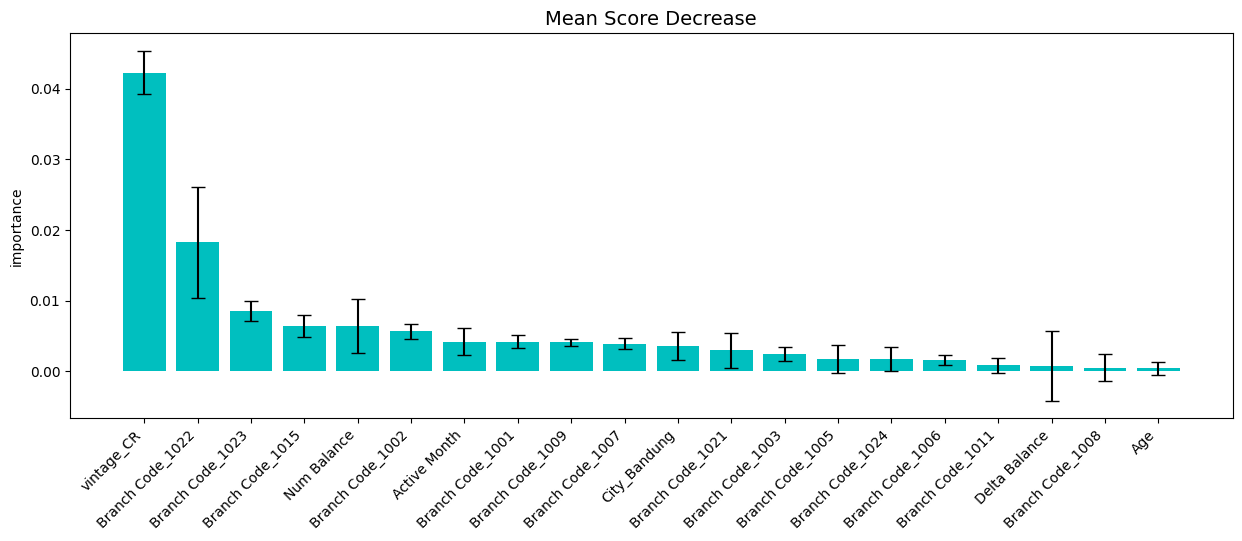

In [144]:
df_imp2 = mean_score_decrease(X2_train,y2_train,grid2,plot=True,topk=20)

#Gradient Boosting

##Eksperimen 1

In [146]:
y11_pred = GB_Grid.predict(X1_test)

In [147]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test,y11_pred))
print("Recall:",metrics.recall_score(y1_test,y11_pred))
metrics.completeness_score

Accuracy: 0.5266637285147642
Recall: 0.8036303630363036


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [148]:
y11_pred_val = GB_Grid.predict(X1_val)

In [150]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val,y11_pred_val))
print("Recall:",metrics.recall_score(y1_val,y11_pred_val))
metrics.completeness_score

Accuracy: 0.4593307763523343
Recall: 0.760797342192691


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

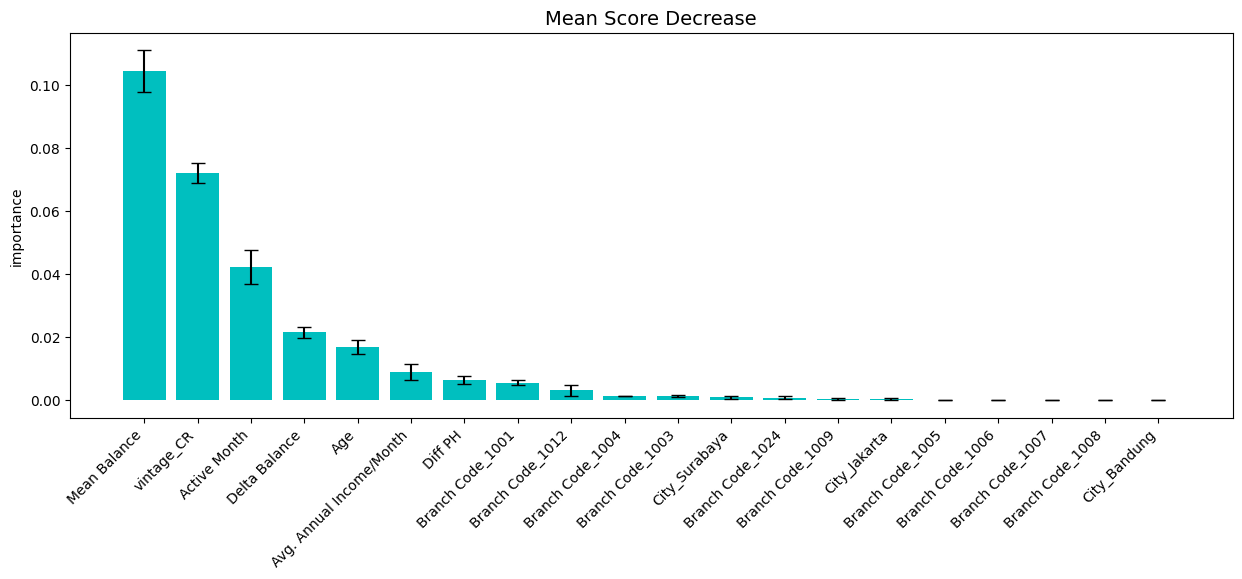

In [151]:
df_imp2 = mean_score_decrease(X1_train,y1_train,GB_Grid,plot=True,topk=20)

##Eksperimen 2

In [152]:
y22_pred = GB_Grid2.predict(X2_test)

In [153]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test,y22_pred))
print("Recall:",metrics.recall_score(y2_test,y22_pred))
metrics.completeness_score

Accuracy: 0.35830762450418685
Recall: 0.9876998769987699


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [155]:
y22_pred_val = GB_Grid2.predict(X2)

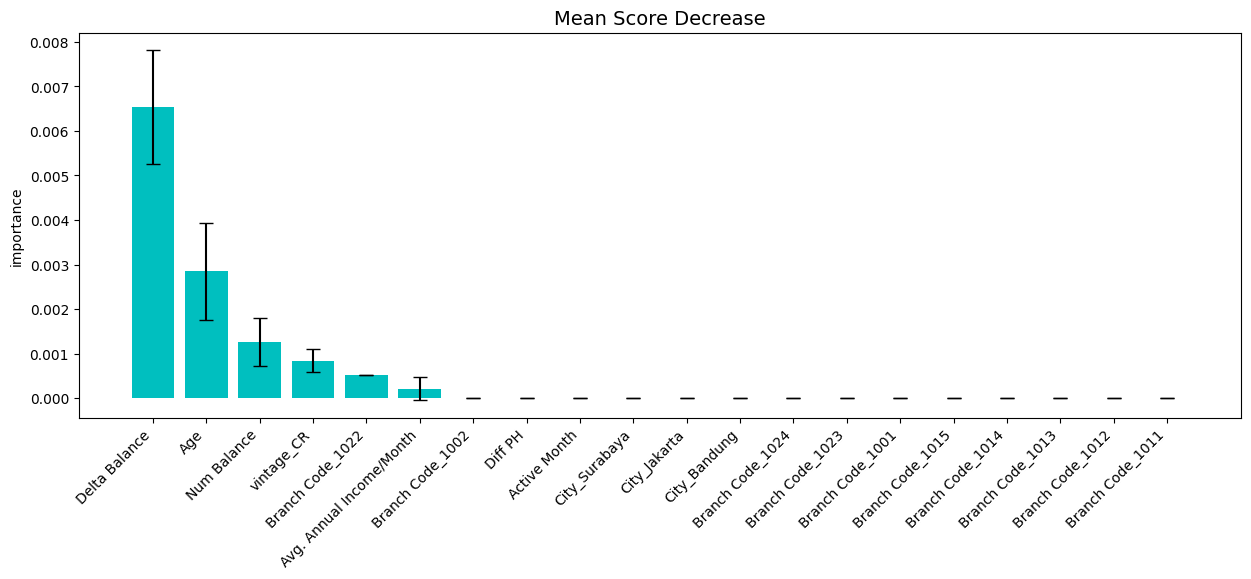

In [157]:
df_imp2 = mean_score_decrease(X2_train,y2_train,GB_Grid2,plot=True,topk=20)

#Random Forest

##Eksperimen 1

In [158]:
y12_pred = RF_Grid.predict(X1_test)

In [161]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_test,y12_pred))
print("Recall:",metrics.recall_score(y1_test,y12_pred))
metrics.completeness_score

Accuracy: 0.8087263111502865
Recall: 0.33663366336633666


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [163]:
y12_pred_val = RF_Grid.predict(X1_val)

In [164]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y1_val,y12_pred_val))
print("Recall:",metrics.recall_score(y1_val,y12_pred_val))
metrics.completeness_score

Accuracy: 0.6705462240444385
Recall: 0.1908453303802141


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

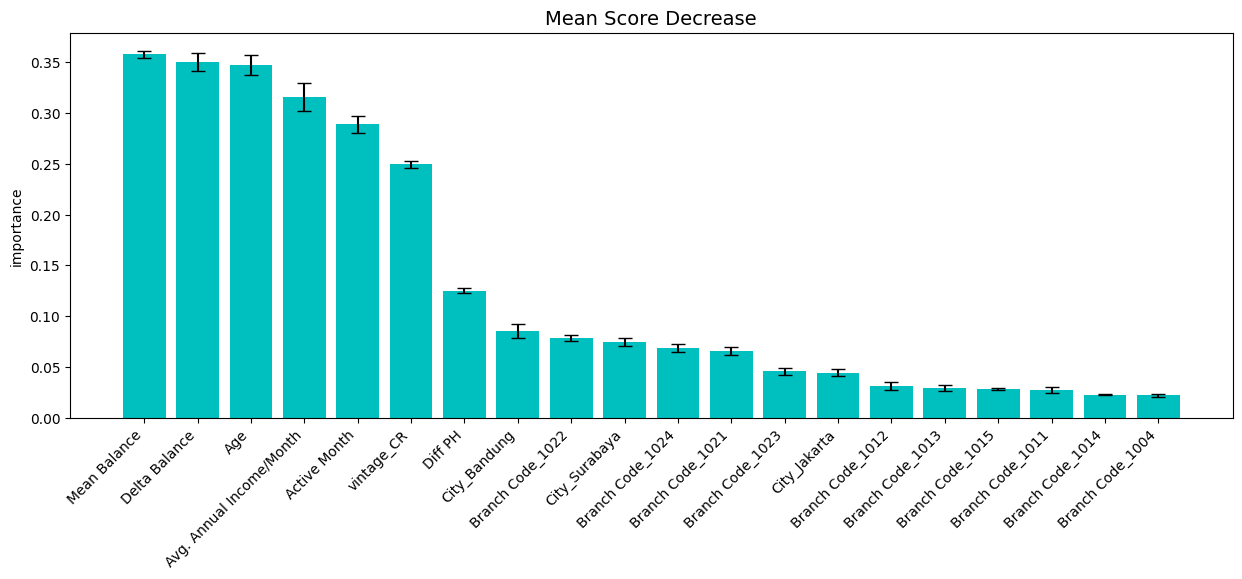

In [167]:
df_imp2 = mean_score_decrease(X1_train,y1_train,RF_Grid,plot=True,topk=20)

##Eksperimen 2

In [169]:
y21_pred = RF_Grid2.predict(X2_test)

In [170]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_test,y21_pred))
print("Recall:",metrics.recall_score(y2_test,y21_pred))
metrics.completeness_score

Accuracy: 0.6408109299250772
Recall: 0.2115621156211562


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

In [172]:
y21_pred_val = RF_Grid2.predict(X2)

In [173]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y2_val,y21_pred_val))
print("Recall:",metrics.recall_score(y2_val,y21_pred_val))
metrics.completeness_score

Accuracy: 0.8551778865229467
Recall: 0.660391288298265


<function sklearn.metrics.cluster._supervised.completeness_score(labels_true, labels_pred)>

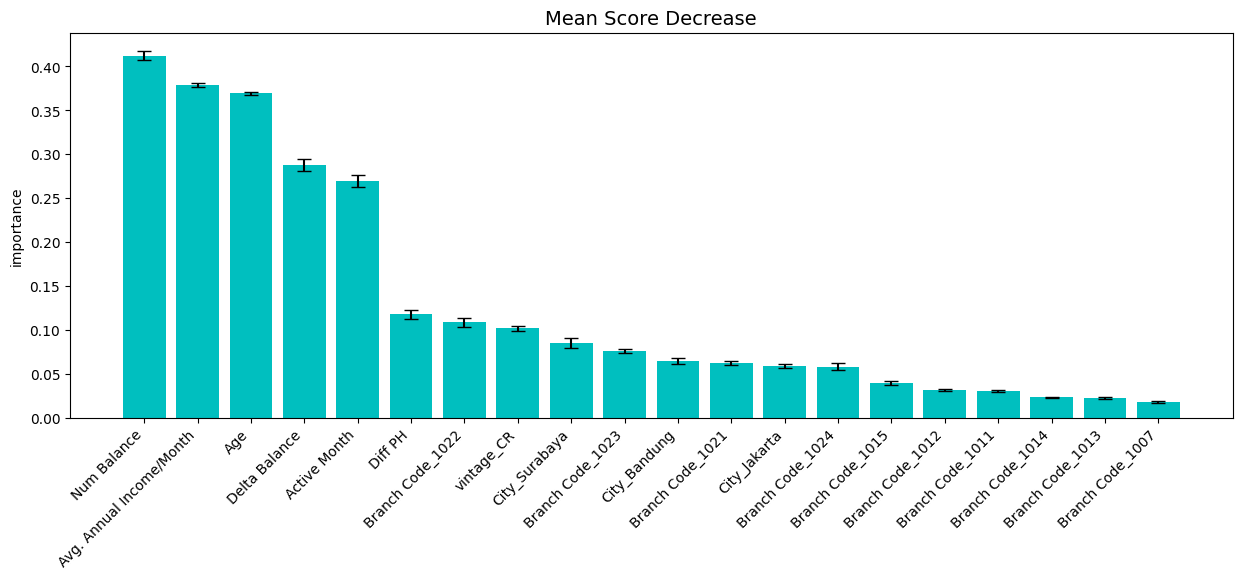

In [174]:
df_imp2 = mean_score_decrease(X2_train,y2_train,RF_Grid2,plot=True,topk=20)

#Kesimpulan
Dari semua model rata-rata memiliki accuracy di atas 60% namun memiliki recall dibawah 40% artinya, masih banyak nasabah yang sebenarnya berpotensi gagal bayar namun diprediksi tidak akan gagal bayar.  Sehingga bisa disampaikan bahwa dalam iterasi pembangunan model kali ini, objektif yang diinginkan masih belum dapat dicapai.

Solusi pengembangan kedepannya yang bisa dilakukan masih belum dapat tercapai:

1. Memperbanyak sample (jumlah nasabah dengan asumsi dataset yang tersedia saat ini bukan total populasi nasabah)
2. Melakukan oversampling terhadap kelas minoritas(gagal bayar) agar pembangunan model tidak bias
3. Memperluas horizon waktu
4. Mencoba variasi variabel lainnya(menambah, variabel baru, atau membuang variabel yang memiliki nilai importance rendah pada hasil terakhir
5. Mencoba memperluas kombinasi hyperparameter dalam pembangunan model
6. Mencoba algoritma supervised machine learning lainnya.